In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pip show module matplotlib

Name: matplotlib
Version: 3.5.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: c:\users\emiol\anaconda3\lib\site-packages
Requires: cycler, fonttools, packaging, kiwisolver, pillow, pyparsing, numpy, python-dateutil
Required-by: seaborn, phik, pandas-profiling, missingno
Note: you may need to restart the kernel to use updated packages.


#Dataset

In [ ]:
bitrate_train = pd.read_csv("bitrate_train.csv")
bitrate_test =  pd.read_csv("bitrate_test.csv")

In [ ]:
bitrate_train.head()

fps_mean   fps_std  rtt_mean    rtt_std  dropped_frames_mean  \
0      24.4  0.516398      91.1   6.723921                  0.0   
1      28.6  2.065591      99.7  15.923777                  0.0   
2      30.0  0.000000      98.1  11.798776                  0.0   
3      30.3  0.948683      99.4  13.014522                  0.0   
4      29.9  0.316228     123.2  62.476307                  0.0   

   dropped_frames_std  dropped_frames_max  bitrate_mean  bitrate_std  target  
0                 0.0                 0.0         460.5     7.648529   616.0  
1                 0.0                 0.0         616.3   155.414893   565.0  
2                 0.0                 0.0         565.2     9.077445   573.0  
3                 0.0                 0.0         573.8    28.350191   585.0  
4                 0.0                 0.0         585.8    59.458295   555.0

In [ ]:
bitrate_train.describe()

fps_mean        fps_std       rtt_mean        rtt_std  \
count  379021.000000  379021.000000  379021.000000  379021.000000   
mean       35.231127       1.725705      49.623858      12.763672   
std        10.975010       2.505942      94.781098     112.684460   
min        10.000000       0.000000       0.000000       0.000000   
25%        28.800000       0.316228      14.300000       0.699206   
50%        30.000000       0.942809      32.200000       1.433721   
75%        43.600000       2.233582      55.900000       4.948625   
max       125.800000     307.167273   12898.400000   40721.933293   

       dropped_frames_mean  dropped_frames_std  dropped_frames_max  \
count        379021.000000       379021.000000       379021.000000   
mean              0.180451            0.469548            1.450719   
std               1.732890            3.157866            9.670928   
min               0.000000            0.000000            0.000000   
25%               0.000000            0.000000            0.000000   
50%               0.000000            0.000000            0.000000   
75%               0.000000            0.000000            0.000000   
max             540.000000          202.385770          640.000000   

        bitrate_mean    bitrate_std         target  
count  379021.000000  379021.000000  379021.000000  
mean     7516.585502    1603.487501    7525.396231  
std      6073.992189    1721.021623    6070.817736  
min         0.000000       0.000000       0.000000  
25%      2773.300000     383.683550    2785.000000  
50%      6287.200000    1112.710010    6296.000000  
75%     10187.200000    2241.848801   10192.000000  
max     64913.500000   26908.532303   64913.000000

We can see that certain values like bitrate_std and bitrate have larger values when compared to the others. This suggests that Scaling our data might help improve the learning.

##Profiling

In [ ]:
from pandas_profiling import ProfileReport
report = ProfileReport(bitrate_train)

In [ ]:
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From Profiling we can see that
   - No need to impute values as we have no missing values
   - We have a number of duplicate rows, they can be dropped as they have no impact on our result, they only serve to increase computation cost
   - Our target is highly correlated with bitrate_mean and bitrate_std, intuitively, we can predict (need to verify)that it majorly impacts our target
   - Dropped values mean, std and max are very highly correlated (multicolinearity?). Can they be replaced with just one of them?
   - Bitrate_std has quite a large number of distinct values, We can consider dropping it and test our result
  

In [ ]:
#inspecting test data set to see if we have no missing values also
bitrate_test.isna().sum()

fps_mean               0
fps_std                0
rtt_mean               0
rtt_std                0
dropped_frames_mean    0
dropped_frames_std     0
dropped_frames_max     0
bitrate_mean           0
bitrate_std            0
target                 0
dtype: int64

No missing values, we can proceed

#Preprocessing

# Drop Duplicates

In [ ]:
#Dropping Duplicates
bitrate_train.drop_duplicates(inplace=True)

## Extracting Target

In [ ]:
bitrate_train_target = bitrate_train["target"]
bitrate_train.drop("target",axis=1,inplace=True)
bitrate_test_target = bitrate_test["target"]
bitrate_test.drop("target", axis = 1, inplace=True)

## Scaling Data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(bitrate_train)
bitrate_train = pd.DataFrame(scaler.transform(bitrate_train), columns = bitrate_train.columns)
bitrate_test = pd.DataFrame(scaler.transform(bitrate_test), columns = bitrate_train.columns)

## Feature Selection

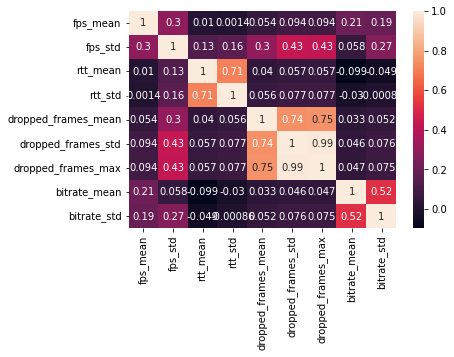

In [ ]:
import seaborn as sb
sb.heatmap(bitrate_train.corr(), annot=True)
plt.show()

We have a correlation of 0.99 between droped_frames_std and dropped_frames_max. We can drop the fields. Also (dropped_frames_mean and dropped_frames_std) (dropped_frames_mean and dropped_frames_max), (rtt_mean and rtt_std) seem to be highly correlated.
We apply additional checks to check for multicollinearity

### Variance inflation factor

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def compute_vif(considered_features, df):
    x = df[considered_features]
    x['intercept'] = 1
    vif = pd.DataFrame()
    vif['Variable'] = x.columns
    vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [ ]:
features_to_be_eliminated = ['dropped_frames_mean','dropped_frames_std','dropped_frames_max','rtt_mean','rtt_std']
compute_vif(features_to_be_eliminated,bitrate_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Variable        VIF
0  dropped_frames_mean   2.332437
1   dropped_frames_std  73.817396
2   dropped_frames_max  76.493841
3             rtt_mean   2.011824
4              rtt_std   2.017252

In [ ]:
#We drop dropped_frames_max and recompute VIF
bitrate_train.drop("dropped_frames_max",axis=1, inplace=True)
bitrate_test.drop("dropped_frames_max",axis=1, inplace=True)

In [ ]:
features_to_be_eliminated = ['dropped_frames_mean','dropped_frames_std','rtt_mean','rtt_std']
compute_vif(features_to_be_eliminated,bitrate_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Variable       VIF
0  dropped_frames_mean  2.239917
1   dropped_frames_std  2.246313
2             rtt_mean  2.011822
3              rtt_std  2.017249

The VIFs are minimal, we have largely reduced the effect of correlation. We should run tests after to see if it affects our model.

# Data Visualisation

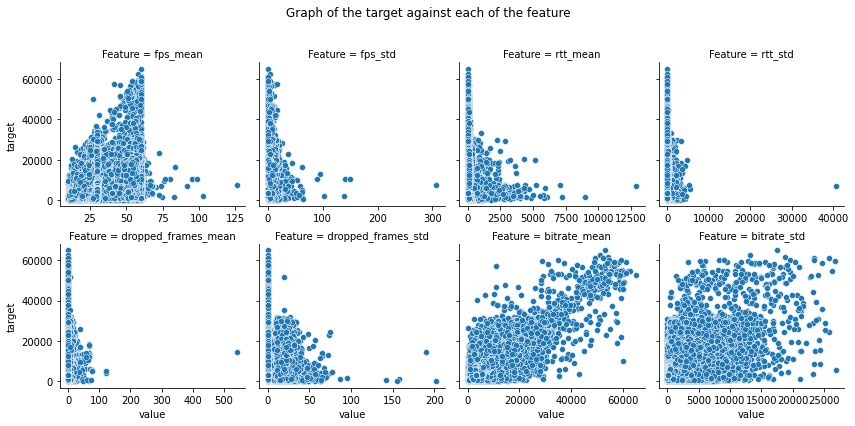

In [ ]:
dfm = bitrate_train.melt(id_vars='target', value_vars=bitrate_train.columns[:-1], var_name='Feature')

p = sb.relplot(kind='scatter', data=dfm, x='value', y='target', height=3,
                col='Feature', col_wrap=4, facet_kws={'sharex': False})
p.fig.suptitle('Graph of the target against each of the feature')
plt.subplots_adjust(top=0.85)
plt.show()

There's a visible relationship between bitrate_mean and the target value. This supports our earlier hypothesis from the correlation results

#Training

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression().fit(bitrate_train, bitrate_train_target)
bitrate_train_pred = linear_reg.predict(bitrate_train)
bitrate_test_pred = linear_reg.predict(bitrate_test)

### Viewing Coefficients and Intercept

In [ ]:
df = pd.DataFrame(index = list(bitrate_train.columns) +["Intercept"])
df["coefficients"] = list(linear_reg.coef_) + [linear_reg.intercept_]
df

coefficients
fps_mean                19.704986
fps_std                  6.730610
rtt_mean               -54.434663
rtt_std                 11.956758
dropped_frames_mean      3.437016
dropped_frames_std     -15.659789
bitrate_mean          5613.283466
bitrate_std            209.500240
Intercept             7563.104560

The bitrate_mean is the largest contributor to our target amongst the measured values, this shows that we were right in our prior analysis. The large values of our intercept shows us that

* external factors not measured influence our target more than the measured values
* or our model isn't the right model for measuring these values.

Amongst the measured values, bitrate_mean seems to be the most important measure affecting our target.

### Performance measurement

In [ ]:
linear_reg_metric_df = pd.DataFrame(index = ["R2 Score", "Mean Squared Error", "Mean Absolute Error"])
linear_reg_metric_df["Training"] = [r2_score(bitrate_train_target, bitrate_train_pred),mean_squared_error(bitrate_train_target, bitrate_train_pred),mean_absolute_error(bitrate_train_target, bitrate_train_pred)]
linear_reg_metric_df["Test"] = [r2_score(bitrate_test_target, bitrate_test_pred),mean_squared_error(bitrate_test_target, bitrate_test_pred),mean_absolute_error(bitrate_test_target, bitrate_test_pred)]
linear_reg_metric_df

Training          Test
R2 Score             8.931187e-01  8.934829e-01
Mean Squared Error   3.935577e+06  3.798473e+06
Mean Absolute Error  1.104711e+03  1.077926e+03

For all metrics, we see that we get very closely related measurements of training and test dataset. Showing that our models isn't overfitting.
To check if our model is underfitting, we will have to check other models out and compare the results.
* The high R2 score shows us that our model captures the variability or the dataset very well, basically shows us tha our model fits the data well.
* The large mean squared error and mean absolute error sugests that we are either underfitting the data.

## Polynomial Regression

### Search for best degree

In [ ]:
#we use grid search to find the best polynomial degree
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([("polynomial_features", PolynomialFeatures()),
                         ("linear_regression", LinearRegression())])
param_grid = {'polynomial_features__degree': [2,3,4,5]}
grid_search = GridSearchCV(pipe, param_grid, cv=10)
grid_search.fit(bitrate_train, bitrate_train_target)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures()),
                                       ('linear_regression',
                                        LinearRegression())]),
             param_grid={'polynomial_features__degree': [2, 3, 4, 5]})

In [ ]:
grid_search.best_params_

{'polynomial_features__degree': 2}

Degree 2 has the best score, we proceed with degree 2

In [ ]:
def PolynomialRegression(degree):
    return Pipeline([("polynomial_features", PolynomialFeatures(degree =degree)),
                         ("linear_regression", LinearRegression())])

poly_reg = PolynomialRegression(2)
poly_reg.fit(bitrate_train, bitrate_train_target)
poly_reg_train_pred = poly_reg.predict(bitrate_train)
poly_reg_test_pred = poly_reg.predict(bitrate_test)

### Performance Measurement

In [ ]:
poly_reg_metric_df = pd.DataFrame(index = ["R2 Score", "Mean Squared Error", "Mean Absolute Error"])
poly_reg_metric_df["Training"] = [r2_score(bitrate_train_target, poly_reg_train_pred),mean_squared_error(bitrate_train_target, poly_reg_train_pred),mean_absolute_error(bitrate_train_target, poly_reg_train_pred)]
poly_reg_metric_df["Test"] = [r2_score(bitrate_test_target, poly_reg_test_pred),mean_squared_error(bitrate_test_target, poly_reg_test_pred),mean_absolute_error(bitrate_test_target, poly_reg_test_pred)]
poly_reg_metric_df

Training          Test
R2 Score             8.945291e-01  8.941205e-01
Mean Squared Error   3.883643e+06  3.775736e+06
Mean Absolute Error  1.075497e+03  1.052732e+03

The polynomial regression gives a bit better values than the linear regression. We have higher training and testing r2 scores and lower mean squared error and mean absolute error.

## Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
def LassoRegression(alpha=0.5, **kwargs):
    polynomial_features = PolynomialFeatures(degree = 2)
    lasso = Lasso(alpha = alpha, max_iter = 5000)
    return Pipeline([("polynomial_features", polynomial_features),
                         ("lasso_regression", lasso)])
lasso = LassoRegression(1)
lasso.fit(bitrate_train, bitrate_train_target)

Pipeline(steps=[('polynomial_features', PolynomialFeatures()),
                ('lasso_regression', Lasso(alpha=1, max_iter=5000))])

In [ ]:
lasso_train_pred = lasso.predict(bitrate_train)
lasso_test_pred = lasso.predict(bitrate_test)

### Performance measurement

In [ ]:
lasso_metric_df = pd.DataFrame(index = ["R2 Score", "Mean Squared Error", "Mean Absolute Error"])
lasso_metric_df["Training"] = [r2_score(bitrate_train_target, lasso_train_pred),mean_squared_error(bitrate_train_target, lasso_train_pred),mean_absolute_error(bitrate_train_target, lasso_train_pred)]
lasso_metric_df["Test"] = [r2_score(bitrate_test_target, lasso_test_pred),mean_squared_error(bitrate_test_target, lasso_test_pred),mean_absolute_error(bitrate_test_target, lasso_test_pred)]
lasso_metric_df

Training          Test
R2 Score             8.945260e-01  8.941292e-01
Mean Squared Error   3.883758e+06  3.775424e+06
Mean Absolute Error  1.075675e+03  1.052730e+03

The Lasso regression produces better values when compared to the polynomial regression. It reduces the effect of overfitting and gives us higher test mean squared error and lower training error. 

# Comparing results

In [ ]:
#Comparing the final result
compDf = linear_reg_metric_df.join(poly_reg_metric_df, lsuffix=" - Linear Regression", rsuffix=" - Polynomial Regression")
compDf = compDf.join(lasso_metric_df.rename(columns={"Training": "Training  - Lasso Regression", "Test": "Test  - Lasso Regression"}))
compDf

Training - Linear Regression  Test - Linear Regression  \
R2 Score                             8.931187e-01              8.934829e-01   
Mean Squared Error                   3.935577e+06              3.798473e+06   
Mean Absolute Error                  1.104711e+03              1.077926e+03   

                     Training - Polynomial Regression  \
R2 Score                                 8.945291e-01   
Mean Squared Error                       3.883643e+06   
Mean Absolute Error                      1.075497e+03   

                     Test - Polynomial Regression  \
R2 Score                             8.941205e-01   
Mean Squared Error                   3.775736e+06   
Mean Absolute Error                  1.052732e+03   

                     Training  - Lasso Regression  Test  - Lasso Regression  
R2 Score                             8.945260e-01              8.941292e-01  
Mean Squared Error                   3.883758e+06              3.775424e+06  
Mean Absolute Error                  1.075675e+03              1.052730e+03